In [1]:
#!/usr/bin/python
import warnings
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', FutureWarning)

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# fetch asset data
def getData(ticker, date_from, date_to):
    data = pdr.DataReader(ticker, 'yahoo', date_from, date_to)
    return data

# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
Y|AAPL|Apple Inc. - Common Stock|Q|Q|N|100|N|N||AAPL|N  
Y|AMZN|Amazon.com, Inc. - Common Stock|Q|Q|N|100|N|N||AMZN|N  
Y|CCEP|Coca-Cola European Partners plc Ordinary Shares|N| |N|100|N||CCEP|CCEP|N  
Y|FB|Facebook, Inc. - Class A Common Stock|Q|Q|N|100|N|N||FB|N  
Y|JNJ|Johnson & Johnson Common Stock|N| |N|100|N||JNJ|JNJ|N  
Y|JWN|Nordstrom, Inc. Common Stock|N| |N|100|N||JWN|JWN|N  
Y|NVS|Novartis AG Common Stock|N| |N|100|N||NVS|NVS|N  
Y|PG|Procter & Gamble Company (The) Common Stock|N| |N|100|N||PG|PG|N  

In [3]:
# obtain Apple Inc stock price data and drop Adj Close column
date_from = datetime.date(2020, 1, 1)
date_to = datetime.date(2020, 8, 31)
df = getData('AAPL', date_from, date_to)
df.drop('Adj Close', axis=1, inplace=True)
df.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2020-08-25,125.180000,123.052498,124.697502,124.824997,211495600.0
2020-08-26,126.992500,125.082497,126.180000,126.522499,163022400.0
2020-08-27,127.485001,123.832497,127.142502,125.010002,155552400.0
2020-08-28,126.442497,124.577499,126.012497,124.807503,187630000.0
2020-08-31,131.000000,126.000000,127.580002,129.039993,225702700.0


In [4]:
def SMA(df, s, l):
    df["sma"] = df.Close.rolling(window=s).mean()
    df["lma"] = df.Close.rolling(window=l).mean()
    df["diff"] = df.sma - df.lma

    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(15, 5))
    plt.plot(xdate, df.Close, label="close")
    plt.plot(xdate, df.sma,label="short")
    plt.plot(xdate, df.lma,label="long")
    plt.xlim(xdate[0], xdate[-1])
    plt.grid()

    # Cross points
    for i in range(1, len(df)):
        if df.iloc[i-1]["diff"] < 0 and df.iloc[i]["diff"] > 0:
            print("{}:GOLDEN CROSS".format(xdate[i]))
            plt.scatter(xdate[i], df.iloc[i]["sma"], marker="o", s=100, color="b", alpha=0.9)

        if df.iloc[i-1]["diff"] > 0 and df.iloc[i]["diff"] < 0:
            print("{}:DEAD CROSS".format(xdate[i]))
            plt.scatter(xdate[i], df.iloc[i]["sma"], marker="o", s=100, color="r", alpha=0.9)

    plt.legend()

2020-02-05:DEAD CROSS
2020-02-06:GOLDEN CROSS
2020-02-11:DEAD CROSS
2020-02-12:GOLDEN CROSS
2020-02-24:DEAD CROSS
2020-04-02:GOLDEN CROSS
2020-07-27:DEAD CROSS
2020-08-03:GOLDEN CROSS


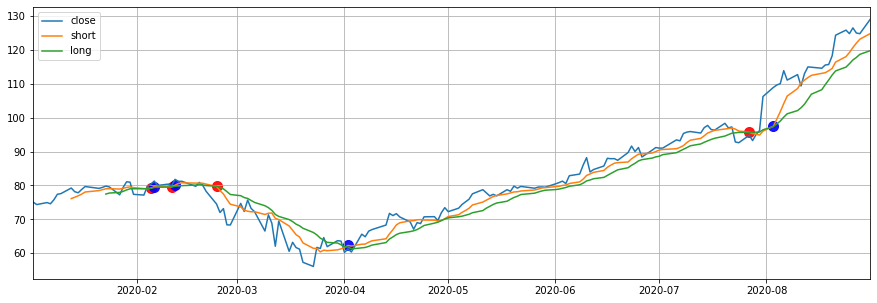

In [5]:
SMA(df, 8, 15)

In [6]:
def MACD(df, s, l, signal):
    df["macd"] = df.Close.ewm(span=s, min_periods=1).mean() - df.Close.ewm(span=l, min_periods=1).mean()
    df["signal"] = df.macd.ewm(span=signal, min_periods=1).mean()
    df["diff"] = df["macd"] - df["signal"]

    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(15, 10))
    
    # plot the original closing line
    plt.subplot(211)
    plt.plot(xdate, df.Close, label="close")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    
    # plot MACD and signal
    plt.subplot(212)
    plt.title("MACD")
    plt.plot(xdate, df.macd, label="macd")
    plt.plot(xdate, df.signal, label="signal")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid(True)

    # Cross points
    for i in range(1, len(df)):
        if df.iloc[i-1]["diff"] < 0 and df.iloc[i]["diff"] > 0:
            print("{}:GOLDEN CROSS".format(xdate[0]))
            plt.scatter(xdate[i], df.iloc[i]["macd"], marker="o", s=100, color="b", alpha=0.9)

        if df.iloc[i-1]["diff"] > 0 and df.iloc[i]["diff"] < 0:
            print("{}:DEAD CROSS".format(xdate[0]))
            plt.scatter(xdate[i], df.iloc[i]["macd"], marker="o", s=100, color="r", alpha=0.9)

2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS
2020-01-02:DEAD CROSS
2020-01-02:GOLDEN CROSS


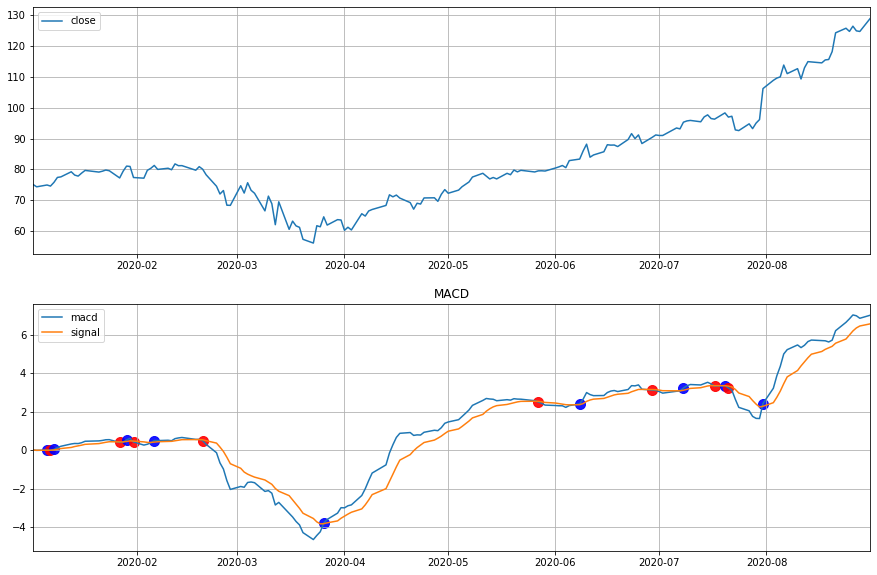

In [7]:
MACD(df, 12, 26, 9)

In [8]:
def plot_RSI(df, window):
    diff = df.Close.diff(periods=1).values
    xdate = [x.date() for x in df.index]
    RSI = []
    for i in range(window+1, len(xdate)):
        neg = 0
        pos = 0
        for value in diff[i-window:i+1]:
            if value > 0:
                pos += value # accumulate positive diff
            if value < 0:
                neg += value # accumulate negative diff
        pos_ave = pos/window # average price of positive diff
        neg_ave = np.abs(neg/window) # average absolute price of negative diff
        rsi = pos_ave/(pos_ave+neg_ave)*100
        RSI.append(rsi)

    # draw RSI figure
    plt.plot(xdate[window+1:], RSI, label = "RSI {}".format(window), lw=2.5, alpha=0.6)
    plt.xlim(xdate[window+1], xdate[-1])
    plt.ylim(0,100)
    plt.legend()

def RSI(df, windows):
    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(15, 10))
    
    # plot the original closing line
    plt.subplot(211)
    plt.plot(xdate, df.Close, label="close")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    
    # plot RSI
    plt.subplot(212)
    plt.grid()
    plt.title("RSI")
    for window in windows:
        plot_RSI(df, window)

    # fill area above 70 and below 30
    plt.fill_between(xdate, np.ones(len(xdate))*30, color="blue", alpha=0.1)
    plt.fill_between(xdate, np.ones(len(xdate))*70, np.ones(len(xdate))*100, color="red", alpha=0.1)
    
    # draw dotted lines at 70 and 30
    plt.plot(xdate, np.ones(len(xdate))*30, color="blue", linestyle="dotted")
    plt.plot(xdate, np.ones(len(xdate))*70, color="red", linestyle="dotted")
    plt.show()

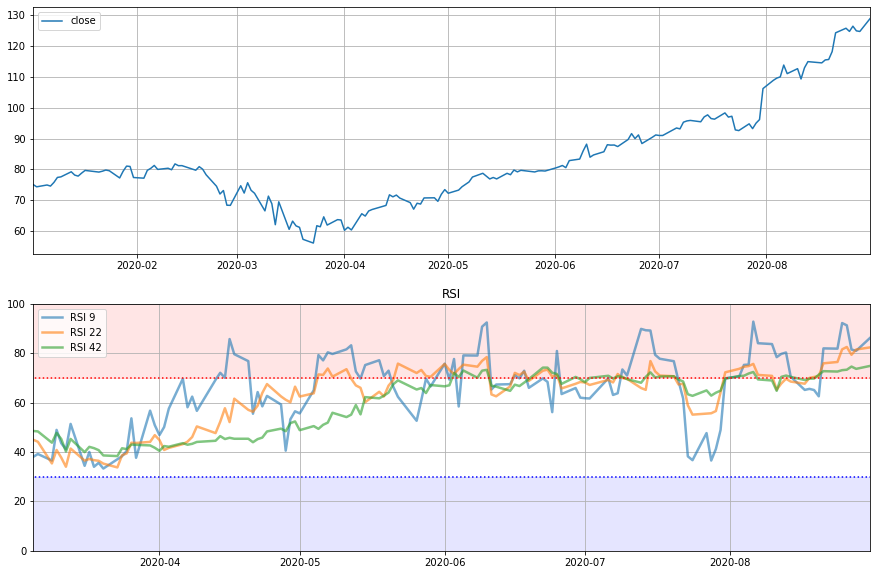

In [9]:
RSI(df, [9, 22, 42])

In [10]:
def OBV(df):
    df["obv"] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], 
                         np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0)).cumsum()
    xdate = [x.date() for x in df.index]
    plt.figure(figsize=(15, 10))
    
    # plot the original closing line
    plt.subplot(211)
    plt.plot(xdate, df.Close, label="close")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid()
    
    # plot volume and OBV
    plt.subplot(212)
    plt.title("OBV")
    # plt.bar(xdate, df.Volume, label="volume")
    plt.plot(xdate, df.obv, label="obv")
    plt.xlim(xdate[0], xdate[-1])
    plt.legend()
    plt.grid(True)

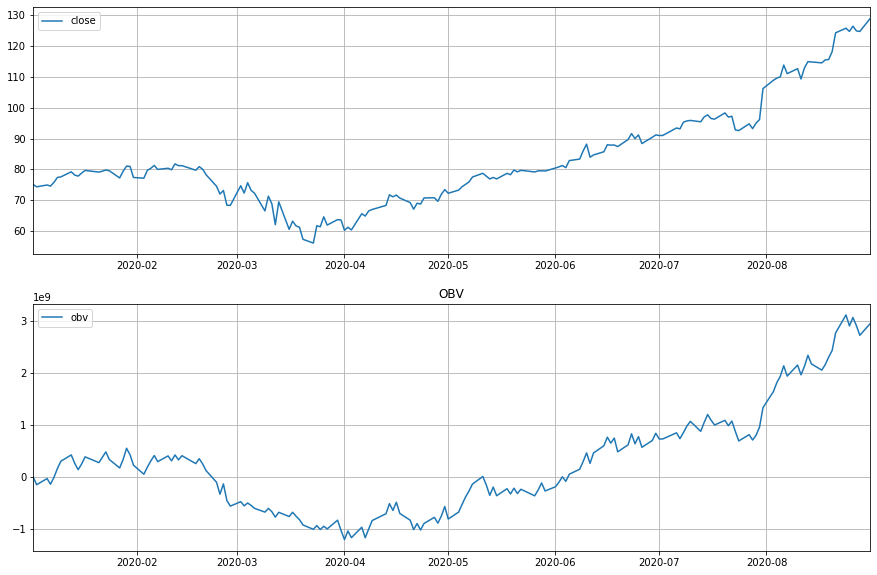

In [11]:
OBV(df)